In [1]:
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdmolops
from rdkit.Chem import RDConfig
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Scaffolds import MurckoScaffold

from collections import defaultdict
from itertools import product
import igraph
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import re
IPythonConsole.ipython_useSVG = True

In [2]:
def gengraph(mols,fpgen , threshold=0.7):
    fps = [fpgen.GetFingerprint(m) for m in mols]
    num_v = len(mols)
    graph = igraph.Graph()
    graph.add_vertices(num_v)
    for i in range(num_v):
        for j in range(i):
            if DataStructs.TanimotoSimilarity(fps[i], fps[j]) >= threshold:
                graph.add_edge(i, j)
    return graph

In [3]:
def makebond(target, chain):
    newmol = Chem.RWMol(rdmolops.CombineMols(target, chain))
    atoms = newmol.GetAtoms()
    mapper = defaultdict(list)
    for idx, atm in enumerate(atoms):
        atom_map_num = atm.GetAtomMapNum()
        mapper[atom_map_num].append(idx)
    for idx, a_list in mapper.items():
        if len(a_list) == 2:
            atm1, atm2 = a_list
            rm_atoms = [newmol.GetAtomWithIdx(atm1),newmol.GetAtomWithIdx(atm2)]
            nbr1 = [x.GetOtherAtom(newmol.GetAtomWithIdx(atm1)) for x in newmol.GetAtomWithIdx(atm1).GetBonds()][0]
            nbr1.SetAtomMapNum(idx)
            nbr2 = [x.GetOtherAtom(newmol.GetAtomWithIdx(atm2)) for x in newmol.GetAtomWithIdx(atm2).GetBonds()][0]
            nbr2.SetAtomMapNum(idx)
    newmol.AddBond(nbr1.GetIdx(), nbr2.GetIdx(), order=Chem.rdchem.BondType.SINGLE)
    nbr1.SetAtomMapNum(0)
    nbr2.SetAtomMapNum(0)
    newmol.RemoveAtom(rm_atoms[0].GetIdx())
    newmol.RemoveAtom(rm_atoms[1].GetIdx())
    newmol = newmol.GetMol()
    return newmol

In [4]:
def enumeratemol(core,rg, maxmol=10000):
    dataset = rg.GetRGroupsAsColumns()
    labels = list(dataset.keys())
    pat = re.compile("R\d+")
    labels = [label for label in labels if pat.match(label)]
    rgs = np.asarray([dataset[label] for label in labels])
    i, j = rgs.shape
    combs = [k for k in product(range(j), repeat=i)]
    res = []
    for i in combs:
        mol = core
        for idx,j in enumerate(i):
            mol = makebond(mol, rgs[idx][j])
        AllChem.Compute2DCoords(mol)
        mol = Chem.RemoveHs(mol)
        res.append(mol)
    return res

In [5]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(2)

In [6]:
mols = [m for m in Chem.SDMolSupplier(os.path.join(RDConfig.RDDocsDir,'Book/data/cdk2.sdf'))]
for mol in mols:
    AllChem.Compute2DCoords(mol)
fps = [fpgen.GetFingerprint(m) for m in mols]

In [7]:
graph = gengraph(mols, fpgen, 0.4)
blks=graph.blocks()
simmols_idx = sorted(list(blks), key=lambda x: len(x), reverse=True)

In [8]:
simmols = [mols[i] for i in simmols_idx[0]]
scaff = [MurckoScaffold.GetScaffoldForMol(m) for m in simmols]

In [9]:
mcs1 = rdFMCS.FindMCS(scaff, threshold=0.7)
mcs2 = rdFMCS.FindMCS(scaff, threshold=0.7, 
                      completeRingsOnly=True,
                      matchValences=True,
                      bondCompare=rdFMCS.BondCompare.CompareOrderExact,
                      atomCompare=rdFMCS.AtomCompare.CompareElements,
                      )
mcs3 = rdFMCS.FindMCS(scaff, threshold=0.7,
                      ringMatchesRingOnly=True,
                      completeRingsOnly=True,
                      atomCompare=rdFMCS.AtomCompare.CompareAny)


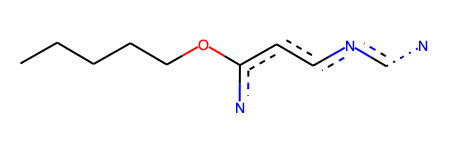

In [10]:
Chem.MolFromSmarts(mcs1.smartsString)

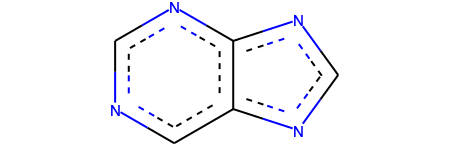

In [11]:
Chem.MolFromSmarts(mcs2.smartsString)

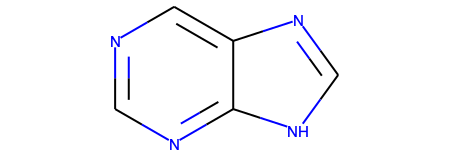

In [12]:
mols_has_core = []
core = Chem.MolFromSmarts(mcs2.smartsString)
for mol in mols:
    if mol.HasSubstructMatch(core):
        AllChem.Compute2DCoords(mol)
        mols_has_core.append(mol)
def getMCSSmiles(mol, mcs):
    mcsp = Chem.MolFromSmarts(mcs.smartsString)
    match = mol.GetSubstructMatch(mcsp)
    smi = Chem.MolFragmentToSmiles(mol, atomsToUse=match)
    return smi
mcs_smi = getMCSSmiles(mols_has_core[0], mcs2)
core = Chem.MolFromSmiles(mcs_smi)
core

In [13]:
rgp = rdRGroupDecomposition.RGroupDecompositionParameters()
rgp.removeHydrogensPostMatch = True
rgp.alignment =True
rgp.removeAllHydrogenRGroups=True
rg = rdRGroupDecomposition.RGroupDecomposition(core, rgp)
for mol in mols_has_core:
    rg.Add(mol)

In [14]:
rg.Process()

True

In [15]:
frame = pd.DataFrame(rg.GetRGroupsAsColumns())
frame["Smiles"] = [Chem.MolToSmiles(mol) for mol in mols_has_core]
PandasTools.AddMoleculeColumnToFrame(frame)

,ROMol,Smiles,Core,R1,R2,R3
0,,CC(C)C(=O)COc1nc(N)nc2[nH]cnc12,,,,
1,,Nc1nc(OCC2CCCO2)c2nc[nH]c2n1,,,,

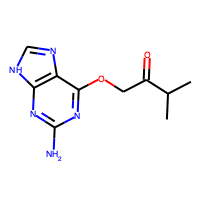
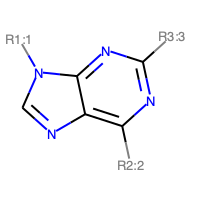
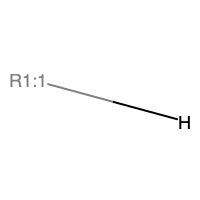
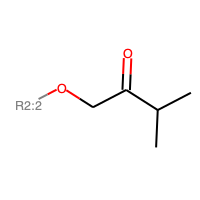
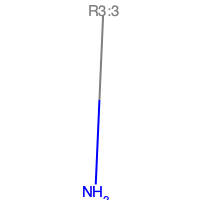
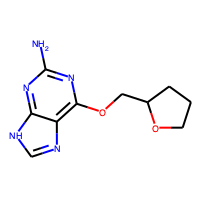
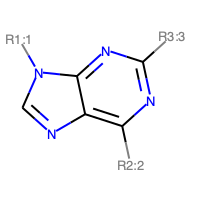
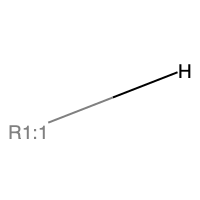
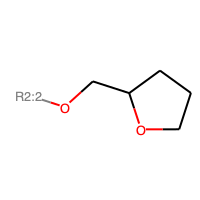
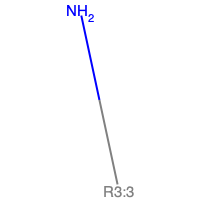

In [16]:
frame = frame[["ROMol", "Smiles", "Core", "R1", "R2", "R3"]]
frame['Core']=frame['Core'].apply(Chem.RemoveHs)
frame.head(2)

In [17]:
dataset = rg.GetRGroupsAsColumns()
core =  Chem.RemoveHs(dataset["Core"][0])

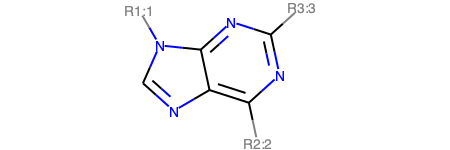

In [55]:
core

In [56]:
res = enumeratemol(core,rg)

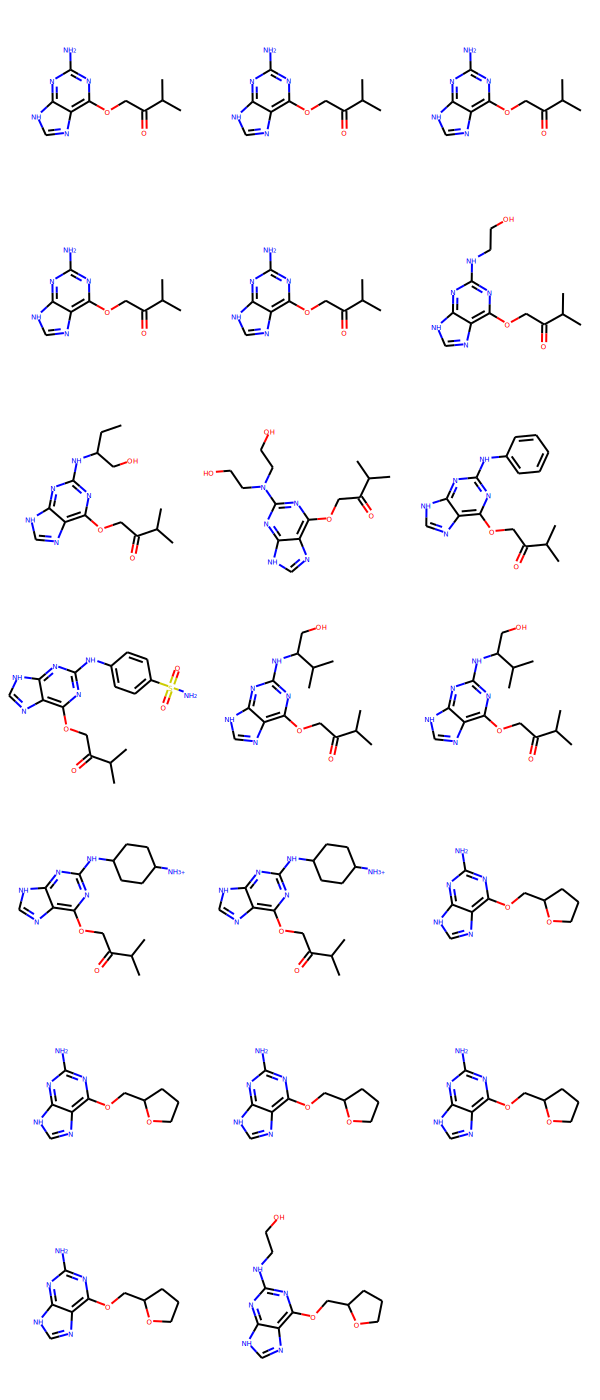

In [59]:
Draw.MolsToGridImage(res[:20])

In [62]:
print(14**3, len(res))

2744 2744
